In [1]:
#Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 10.9 MB/s eta 0:00:00


In [3]:
#Importing dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn import linear_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy.stats import zscore
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [4]:
#Load dataset
data=pd.read_csv("YOUR_PATH.csv") #SUB WITH YOUR PATH!!!
data.head()

,recordid,SAPS-I,SOFA,In-hospital_death,Age,Gender,Height,Weight,CCU,CSRU,...,Platelets_last,TroponinI_last,TroponinT_last,WBC_last,Weight_last,pH_last,MechVentStartTime,MechVentDuration,MechVentLast8Hour,UrineOutputSum
0,132539,6,1,0,54.0,0.0,NaN,NaN,0,0,...,185.0,NaN,NaN,9.4,NaN,NaN,NaN,NaN,NaN,NaN
1,132540,16,8,0,76.0,1.0,175.3,76.0,0,1,...,135.0,NaN,NaN,13.3,81.6,7.37,71.0,360.0,0.0,5.0
2,132541,21,11,0,44.0,0.0,NaN,56.7,0,0,...,113.0,NaN,NaN,6.2,56.7,7.47,617.0,2160.0,1.0,14.0
3,132543,7,1,0,68.0,1.0,180.3,84.6,0,0,...,284.0,NaN,NaN,7.9,84.6,NaN,NaN,NaN,NaN,NaN
4,132545,17,2,0,88.0,0.0,NaN,NaN,0,0,...,97.0,NaN,NaN,4.8,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#Data cleaning
data=data.dropna(axis=1,thresh=5000)  #Keep only features wih at least 5000 observations
y=data['In-hospital_death'] #Set in-hospital mortality as target
data=data.drop(columns=['recordid', 'Gender','CCU','CSRU','SICU','In-hospital_death'])  #Drop non-informative features
data['SAPS-I']=data['SAPS-I'].replace(-1, np.NaN) #Remove non-plausible datapoints (feature can't assume -1 value)
data['SOFA']=data['SOFA'].replace(-1, np.NaN) #Remove non-plausible datapoints (feature can't assume -1 value)
#Naive method to remove outliers
for column in data.columns:
    q75,q25 = np.percentile(data.loc[:,column],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    data.loc[data[column] < min,column] = np.nan
    data.loc[data[column] > max,column] = np.nan
#Standardize data
for column in reversed(data.columns):
  data[column] = (data[column] - data[column].mean())/data[column].std(ddof=0)
data.head()

,SAPS-I,SOFA,Age,Weight,GCS_first,Glucose_first,HR_first,NIDiasABP_first,NIMAP_first,NISysABP_first,...,WBC_first,BUN_last,Creatinine_last,HCO3_last,HCT_last,K_last,Mg_last,Na_last,Platelets_last,WBC_last
0,-1.718025,-1.384012,-0.605474,NaN,0.998813,0.735036,-0.823560,0.264746,0.727181,0.984452,...,-0.207914,-0.847381,-0.475433,0.878260,-0.115172,-0.136126,-0.455401,-0.663041,-0.066868,-0.439315
1,0.208335,0.341116,0.653931,-0.226738,-1.453064,-0.571933,-0.077611,-1.324404,-1.706085,-1.915681,...,-0.687416,-0.216325,-0.041977,-0.058731,-0.308862,-1.113001,-0.455401,-0.893423,-0.553342,0.164250
2,1.171516,1.080457,-1.177930,-1.047376,-0.635772,-0.101424,0.519147,1.383037,1.178184,0.443094,...,-1.091206,-1.090095,-0.764404,0.175517,-0.308862,-0.722251,-1.082025,-0.202278,-0.767390,-0.934548
3,-1.525389,-1.384012,0.195965,0.138935,0.998813,-0.258260,-0.525180,0.147031,0.406896,0.481762,...,-0.170059,-0.750295,-0.475433,0.878260,1.176095,-0.526876,-0.455401,-0.432660,0.896349,-0.671455
4,0.400971,-1.137565,1.340878,NaN,0.998813,-0.467375,0.171038,-1.147832,-0.234808,0.868446,...,-1.141680,-0.022154,-0.258705,-0.995722,0.013955,0.059249,-1.395337,0.028103,-0.923062,-1.151212


In [7]:
#Impute missing data with K-NN
imputer = KNNImputer(n_neighbors=60)
X_imputed=imputer.fit_transform(data)

In [14]:
#split the dataset into training (80%) and testing (20%) sets
X_train,X_test,y_train,y_test = train_test_split(X_imputed,y,test_size=0.2,random_state=42)

#initialize the model
log_regression = LogisticRegression()

#fit the model using the training data
log_regression.fit(X_train,y_train)

LogisticRegression()

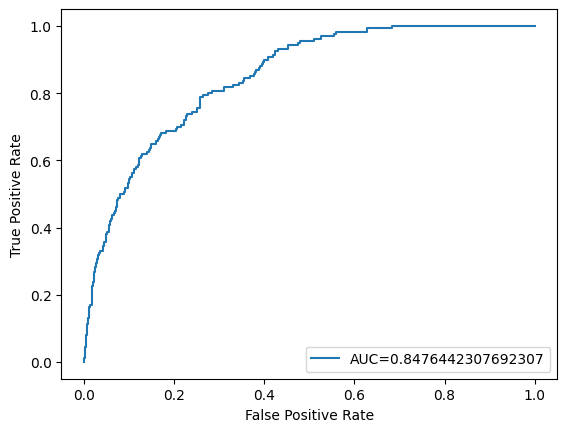

In [15]:
#generate predictions
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
y_pred= log_regression.predict(X_test)
#Get performance metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [16]:
#Classification report
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test,y_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test,y_pred))

=== Confusion Matrix ===
[[1009   31]
 [ 111   49]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1040
           1       0.61      0.31      0.41       160

    accuracy                           0.88      1200
   macro avg       0.76      0.64      0.67      1200
weighted avg       0.86      0.88      0.86      1200



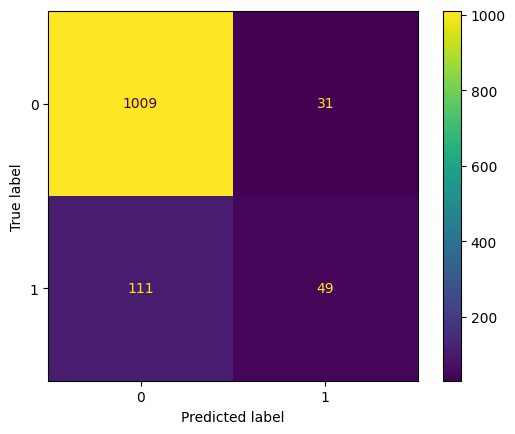

In [17]:
#Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [18]:
#Geat feature importance with shapley
import shap
explainer = shap.Explainer(log_regression, X_test)
shap_values = explainer(X_test)

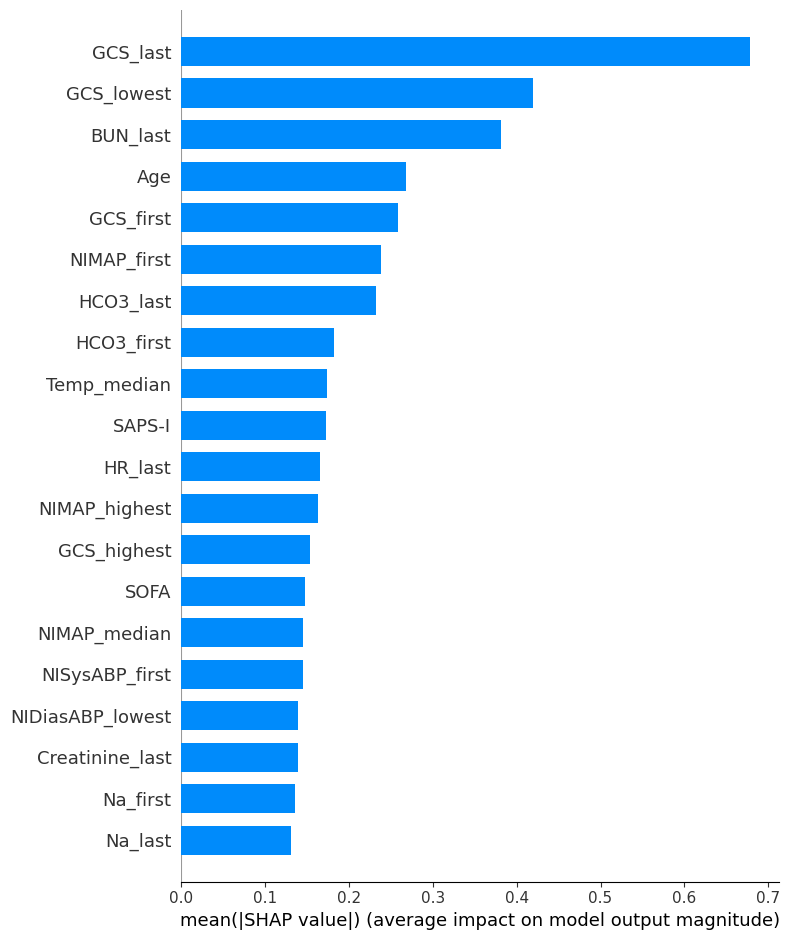

In [19]:
#Plot feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar",feature_names=data.columns)

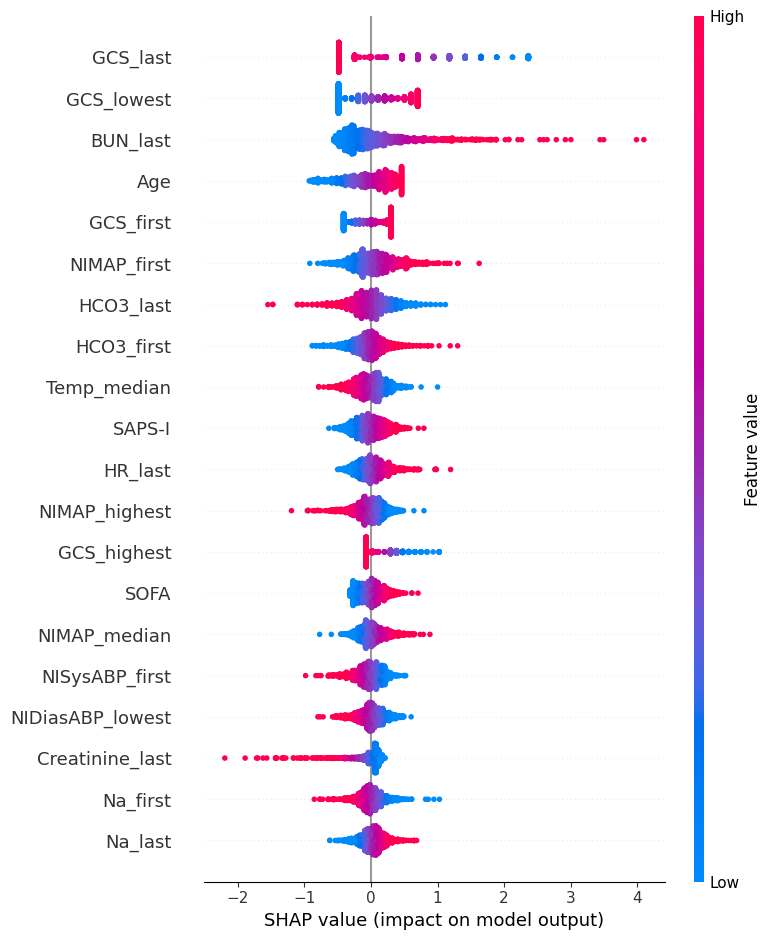

In [20]:
#Plot features effect
shap.summary_plot(shap_values, X_test,feature_names=data.columns)